Mount Google Drive

In [ ]:
from google.colab import drive

# Mount Google Drive at the specified path
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Data Preprocessing

1. Extract position, velocity, and torque data measurements from CSV files

In [ ]:
import pandas as pd
import numpy as np
import random
import os

# Initialize empty lists to store position, velocity, and torque data measurements from all trajectories
pos_data = []
vel_data = []
Pos = []
Vel = []
Trq = []
trajectory_lengths = []

# Specify the path to your data csv files
csv_folder = "/content/drive/MyDrive/EECE 798K Data-Driven Modelling/Project/Data in CSV form"

# Extract position, velocity, and torque columns
pos_columns = [f"posa{i}.txt" for i in range(1, 6)]
vel_columns = [f"vela{i}.txt" for i in range(1, 6)]
trq_columns = [f"trq{i}.txt" for i in range(1, 6)]

# Shuffle the order of trajectories for later splitting
random.seed(42)
numbers = list(range(1, 13))
random.shuffle(numbers)

for j in numbers:
  # Read the CSV file corresponding to one trajectory
  csv_file = os.path.join(csv_folder, f"traj{j}.csv")

  df = pd.read_csv(csv_file)

  # Append position, velocity, and torque data measurements to lists
  pos_data = df[pos_columns].values
  vel_data = df[vel_columns].values
  trq_data = df[trq_columns].values
  Pos.append(pos_data)
  Vel.append(vel_data)
  Trq.append(trq_data)

  # Save the length (nb of samples) of each trajectory
  trajectory_lengths.append(len(pos_data))


# Concatenate position, velocity, and torque data from all trajectories
P = np.concatenate(Pos, axis=0)
V = np.concatenate(Vel, axis=0)
T = np.concatenate(Trq, axis=0)

# Print shapes
print("Shape of matrix P:", P.shape)
print("Shape of matrix V:", V.shape)
print("Shape of matrix T:", T.shape)

Shape of matrix P: (8513, 5)
Shape of matrix V: (8513, 5)
Shape of matrix T: (8513, 5)


2. Create Data matrix from joints positions and velocities and Output matrix from joints torques

In [ ]:
# Data matrix
Data_matrix = np.concatenate((P, V), axis=1)
Data_matrix.shape

(8513, 10)

In [ ]:
# Output matrix
Output_matrix = T
Output_matrix.shape

(8513, 5)

In [ ]:
# length of each trajectory
trajectory_lengths

[572, 966, 548, 564, 580, 624, 514, 754, 926, 710, 1154, 601]

3. Filter the Data with a low-pass filter to get rid of noise resulting from sensors

In [ ]:
import numpy as np
from scipy.signal import butter,filtfilt


fs = 1000.0      # sample rate (Hz)
cutoff = 10      # desired cutoff frequency of the filter (Hz)
nyq = 0.5 * fs   # Nyquist Frequency (Hz)
order = 2        # signal can be approximately represented as quadratic


def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [ ]:
# Filter torque measurements
Output_matrix_filtered = np.zeros((Output_matrix.shape[0], Output_matrix.shape[1]))

for i in range(Output_matrix.shape[1]):
    Output_matrix_filtered[:, i] = butter_lowpass_filter(Output_matrix[:,i], cutoff, fs, order)

In [ ]:
# Filter position and velocity measurements
Data_matrix_filtered = np.zeros((Data_matrix.shape[0], Data_matrix.shape[1]))

for i in range(Data_matrix.shape[1]):
    Data_matrix_filtered[:, i] = butter_lowpass_filter(Data_matrix[:,i], cutoff, fs, order)

4. Visualize both original and filtered data for the five joints on a sample trajectory

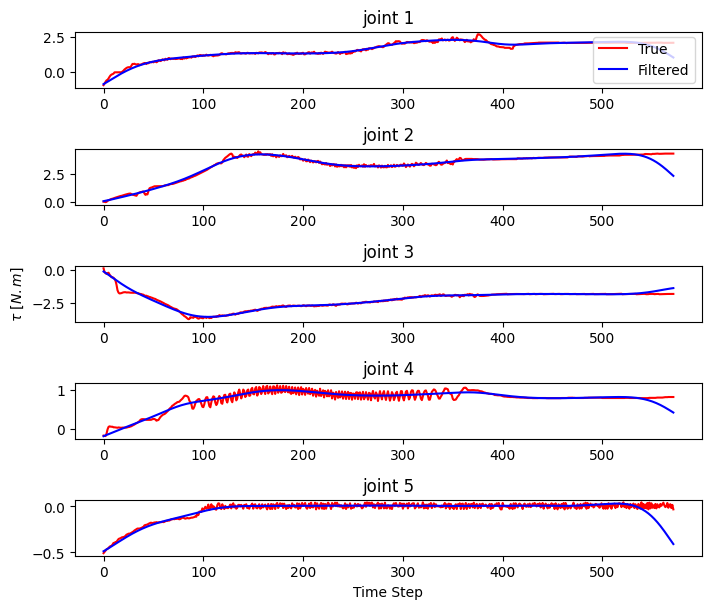

In [ ]:
# Visualize original and filtered torque data on the first trajectory

import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 1, figsize=(7,6))

# Plot each output separately
for k, ax in enumerate(axs):
  ax.plot(Output_matrix[:trajectory_lengths[0], k], label='True', color='red')
  ax.plot(Output_matrix_filtered[:trajectory_lengths[0], k], label='Filtered', color='blue')
  ax.set_title(f'joint {k+1}')

plt.tight_layout()
plt.xlabel('Time Step')
axs[0].legend(loc='right')
axs[2].set_ylabel(r'$\tau$ [$N.m$]')
plt.show()

5. Approximate joints accelerations by differentiating joints velocities w.r.t time

In [ ]:
# Extract time instants and joint positions

nb_time_steps = len(Data_matrix)
t_final  = (1/1000)*nb_time_steps
time_instants = np.linspace(0, t_final, nb_time_steps)
joint_positions = Data_matrix_filtered[:, 0:5]
joint_velocities = Data_matrix_filtered[:, 5:]

# Compute joint accelerations using np.gradient on velocities
joint_accelerations = np.gradient(joint_velocities, 1/1000, axis=0)

(8513, 15)

6. Concatenate joints accelerations into the data matrix

In [ ]:
# Concatenate joint positions, velocities, and accelerations
data_matrix_with_acceleration = np.concatenate((Data_matrix_filtered, joint_accelerations), axis=1)

# Now data_matrix_with_acceleration contains the original data_matrix with additional columns for joint accelerations
data_matrix_with_acceleration.shape

7. Create a new data matrix including all possible combinations of summations of joints positions as columns (this will be used later for applying sines and cosines)

In [ ]:
import itertools

def calculate_sums(matrix):
    sums = []
    headers = []

    for r in range(1, 6):
        combinations = itertools.combinations(range(5), r)
        for combo in combinations:
            sum_column = np.sum(matrix[:, combo], axis=1)
            header_label = '+'.join([f'q{col+1}' for col in combo])
            headers.append(header_label)
            sums.append(sum_column)

    data_matrix = np.array(sums).T
    return data_matrix, headers


new_data_matrix_without_acceleration, headers = calculate_sums(data_matrix_with_acceleration)
new_data_matrix_with_acceleration = np.concatenate((new_data_matrix_without_acceleration, data_matrix_with_acceleration[:,-10:]), axis=1)
new_data_matrix_with_acceleration.shape

(8513, 41)

In [ ]:
headers

['q1',
 'q2',
 'q3',
 'q4',
 'q5',
 'q1+q2',
 'q1+q3',
 'q1+q4',
 'q1+q5',
 'q2+q3',
 'q2+q4',
 'q2+q5',
 'q3+q4',
 'q3+q5',
 'q4+q5',
 'q1+q2+q3',
 'q1+q2+q4',
 'q1+q2+q5',
 'q1+q3+q4',
 'q1+q3+q5',
 'q1+q4+q5',
 'q2+q3+q4',
 'q2+q3+q5',
 'q2+q4+q5',
 'q3+q4+q5',
 'q1+q2+q3+q4',
 'q1+q2+q3+q5',
 'q1+q2+q4+q5',
 'q1+q3+q4+q5',
 'q2+q3+q4+q5',
 'q1+q2+q3+q4+q5']

8. Split data into 8 trajectories for training, 2 for validation, and 2 for testing

In [ ]:
import numpy as np

# Determine the number of trajectories for each set
num_train_trajectories = 8
num_val_trajectories = 2
num_test_trajectories = 2

train_data = new_data_matrix_with_acceleration[0:5122, :]
train_output = Output_matrix_filtered[0:5122, :]

val_data = new_data_matrix_with_acceleration[5122:6758, :]
val_output = Output_matrix_filtered[5122:6758, :]

test_data = new_data_matrix_with_acceleration[6758:, :]
test_output = Output_matrix_filtered[6758:, :]

# print the number of data samples in each set
print("Shape of train set:", train_data.shape, train_output.shape)
print("Shape of validation set:", val_data.shape, val_output.shape)
print("Shape of test set:", test_data.shape, test_output.shape)

Shape of train set: (5122, 41) (5122, 5)
Shape of validation set: (1636, 41) (1636, 5)
Shape of test set: (1755, 41) (1755, 5)


# Training using PySINDY

In [ ]:
!pip install pysindy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 kB 3.4 MB/s eta 0:00:00


1. Create a feature library of polynomials and trigonometric functions, based on our knowledge of simpler systems (2-Dof robotic manipulators)

In [ ]:
from pysindy.feature_library import PolynomialLibrary, FourierLibrary, IdentityLibrary, GeneralizedLibrary, CustomLibrary

id_library = IdentityLibrary() # to be fitted to joints acceleration

fourier_library = FourierLibrary() # to be fitted to all possible combinations of summation of joints angles

In [ ]:
poly_lib = PolynomialLibrary(degree=2) # to be fitted to joints velocities

sin_function = [lambda x : np.sin(x)]
fct_name_sin = [lambda x: 'sin(' + x + ')']
sin_lib = CustomLibrary(library_functions=sin_function, function_names=fct_name_sin) # to be fitted to joints angles

cos_function = [lambda x : np.cos(x)]
fct_name_cos = [lambda x: 'cos(' + x + ')']
cos_lib = CustomLibrary(library_functions=cos_function, function_names=fct_name_cos) # to be fitted to joints angles

In [ ]:
# create a matrix that decides on all columns of the data matrix that will be included in each of the five defined libraries
inputs_temp = np.tile(list(range(41)),5)

inputs_per_library = np.reshape(inputs_temp, (5,41))

inputs_per_library[0, 0:36] = 36
inputs_per_library[1, 5:] = 4
inputs_per_library[2, 5:] = 4
inputs_per_library[3, 0:31] = 31
inputs_per_library[3, 36:] = 35
inputs_per_library[4, 31:] = 30
inputs_per_library

array([[36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
        36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
        36, 36, 36, 36, 36, 37, 38, 39, 40],
       [ 0,  1,  2,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4],
       [ 0,  1,  2,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4],
       [31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
        31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
        32, 33, 34, 35, 35, 35, 35, 35, 35],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 30,
        30, 30, 30, 30, 30, 30, 30, 30, 30]])

In [ ]:
# create a variable that decides on possible combinations of libraries
tensor_array = [[1, 1, 0, 0, 0], [1, 0, 1, 0, 0], [0, 0, 1, 1, 0]]

In [ ]:
# Define a generalized library of the previously defined five libraries with possible combinations
generalized_library = GeneralizedLibrary([id_library, cos_lib, sin_lib, poly_lib, fourier_library], tensor_array=tensor_array, inputs_per_library=inputs_per_library)

2. Fit a SINDY model into training data using LASSO regression

In [ ]:
import pysindy as ps
from sklearn.linear_model import Lasso
from pysindy import SINDy

opt = Lasso(alpha=0.029)

features = headers + ['q1_dot', 'q2_dot', 'q3_dot', 'q4_dot', 'q5_dot', 'q1_ddot', 'q2_ddot', 'q3_ddot', 'q4_ddot', 'q5_ddot']
model = ps.SINDy(optimizer=opt, feature_library=generalized_library, feature_names=features)
model.fit(train_data, x_dot = train_output)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.388e-01, tolerance: 1.325e-01
  model = cd_fast.enet_coordinate_descent(


SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=<pysindy.feature_library.generalized_library.GeneralizedLibrary object at 0x7aabc7b17880>,
      feature_names=['q1', 'q2', 'q3', 'q4', 'q5', 'q1+q2', 'q1+q3', 'q1+q4',
                     'q1+q5', 'q2+q3', 'q2+q4', 'q2+q5', 'q3+q4', 'q3+q5',
                     'q4+q5', 'q1+q2+q3', 'q1+q2+q4', 'q1+q2+q5', 'q1+q3+q4',
                     'q1+q3+q5', 'q1+q4+q5', 'q2+q3+q4', 'q2+q3+q5', 'q2+q4+q5',
                     'q3+q4+q5', 'q1+q2+q3+q4', 'q1+q2+q3+q5', 'q1+q2+q4+q5',
                     'q1+q3+q4+q5', 'q2+q3+q4+q5', ...],
      optimizer=Lasso(alpha=0.029))

In [ ]:
# Print the model equations

model.equations()

['-0.152 q1_ddot + 0.019 cos(q1) + 0.323 q1_dot^2 + 0.019 cos(1 q1) + -0.423 cos(1 q1+q4) + -0.250 cos(1 q1+q5) + -0.094 cos(1 q1+q2+q4) + 0.372 sin(1 q1+q3+q4) + 0.429 sin(1 q1+q2+q4+q5) + 0.266 q1_ddot cos(q5) + 0.010 q2_ddot cos(q1) + -0.047 q3_ddot cos(q1) + 0.030 q3_ddot cos(q2) + 0.003 q4_ddot cos(q1) + 0.129 q3_ddot sin(q1) + -0.025 q3_ddot sin(q2) + 0.023 q4_ddot sin(q3) + 0.964',
 '-0.031 q1_ddot + 0.053 q5_ddot + -0.153 cos(q1) + 0.544 cos(q2) + 1.021 q1_dot + -0.181 q3_dot + -0.153 cos(1 q1) + 0.544 cos(1 q2) + -0.839 cos(1 q1+q4) + -1.261 sin(1 q1+q5) + -2.511 sin(1 q2+q3) + 0.927 sin(1 q2+q4) + 0.067 cos(1 q2+q4) + 1.412 cos(1 q3+q5) + -3.045 sin(1 q2+q3+q4) + 0.098 sin(1 q2+q4+q5) + 0.229 q2_ddot cos(q2) + -0.468 q3_ddot cos(q2) + 0.380 q3_ddot cos(q4) + 0.021 q4_ddot cos(q1) + 0.171 q4_ddot cos(q2) + -0.271 q4_ddot cos(q3) + -0.014 q4_ddot cos(q5) + 0.057 q5_ddot cos(q5) + 0.149 q1_ddot sin(q1) + -0.044 q1_ddot sin(q4) + -0.142 q2_ddot sin(q2) + 0.561 q3_ddot sin(q2) + -

In [ ]:
# Print the model coefficients

model.coefficients()

array([[-0.15160799,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.03080825,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.00219281,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
# Print the model features (terms resulting from the constructed generalized library)

model.get_feature_names()

['q1_ddot',
 'q2_ddot',
 'q3_ddot',
 'q4_ddot',
 'q5_ddot',
 'cos(q1)',
 'cos(q2)',
 'cos(q3)',
 'cos(q4)',
 'cos(q5)',
 'sin(q1)',
 'sin(q2)',
 'sin(q3)',
 'sin(q4)',
 'sin(q5)',
 '1',
 'q1_dot',
 'q2_dot',
 'q3_dot',
 'q4_dot',
 'q5_dot',
 'q1_dot^2',
 'q1_dot q2_dot',
 'q1_dot q3_dot',
 'q1_dot q4_dot',
 'q1_dot q5_dot',
 'q2_dot^2',
 'q2_dot q3_dot',
 'q2_dot q4_dot',
 'q2_dot q5_dot',
 'q3_dot^2',
 'q3_dot q4_dot',
 'q3_dot q5_dot',
 'q4_dot^2',
 'q4_dot q5_dot',
 'q5_dot^2',
 'sin(1 q1)',
 'cos(1 q1)',
 'sin(1 q2)',
 'cos(1 q2)',
 'sin(1 q3)',
 'cos(1 q3)',
 'sin(1 q4)',
 'cos(1 q4)',
 'sin(1 q5)',
 'cos(1 q5)',
 'sin(1 q1+q2)',
 'cos(1 q1+q2)',
 'sin(1 q1+q3)',
 'cos(1 q1+q3)',
 'sin(1 q1+q4)',
 'cos(1 q1+q4)',
 'sin(1 q1+q5)',
 'cos(1 q1+q5)',
 'sin(1 q2+q3)',
 'cos(1 q2+q3)',
 'sin(1 q2+q4)',
 'cos(1 q2+q4)',
 'sin(1 q2+q5)',
 'cos(1 q2+q5)',
 'sin(1 q3+q4)',
 'cos(1 q3+q4)',
 'sin(1 q3+q5)',
 'cos(1 q3+q5)',
 'sin(1 q4+q5)',
 'cos(1 q4+q5)',
 'sin(1 q1+q2+q3)',
 'cos(1 q1+q2+

# Evaluation

1. Evaluate the model using MSE on train, validation, and test sets

In [ ]:
# Compute training MSE

from sklearn.metrics import mean_squared_error

train_predictions = model.predict(train_data)
mse = mean_squared_error(train_output, train_predictions)
print("Train MSE:", mse)

Train MSE: 0.48731756188358755


In [ ]:
# Compute validation MSE

val_predictions = model.predict(val_data)
mse = mean_squared_error(val_output, val_predictions)
print("Validation MSE:", mse)

Validation MSE: 0.6487018935850641


In [ ]:
# Compute testing MSE

test_predictions = model.predict(test_data)
mse = mean_squared_error(test_output, test_predictions)
print("Test MSE:", mse)

Test MSE: 1.539702201295301


2. Plot the true and predicted torques on validation and test trajectories for the five joints

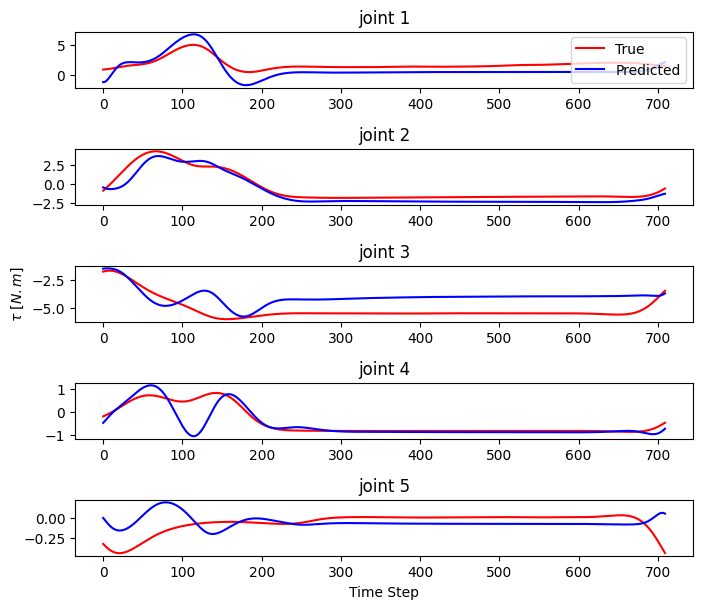

In [ ]:
# Plot the output on the first validation trajectory

import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 1, figsize=(7,6))

# Plot each output separately
for k, ax in enumerate(axs):
  ax.plot(val_output[926:, k], label='True', color='red')
  ax.plot(val_predictions[926:, k], label='Predicted', color='blue')
  ax.set_title(f'joint {k+1}')

plt.tight_layout()
plt.xlabel('Time Step')
axs[0].legend(loc='right')
axs[2].set_ylabel(r'$\tau$ [$N.m$]')
plt.show()

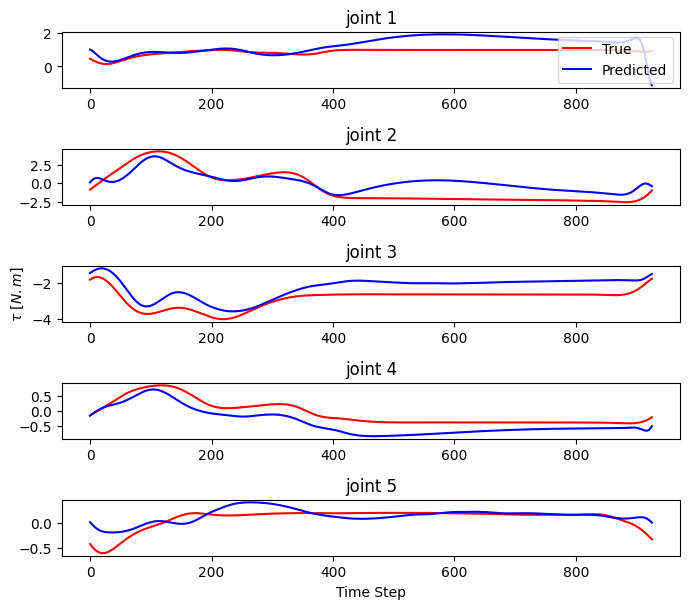

In [ ]:
# Plot the output on the second validation trajectory

fig, axs = plt.subplots(5, 1, figsize=(7,6))

# Plot each output separately
for k, ax in enumerate(axs):
  ax.plot(val_output[:926, k], label='True', color='red')
  ax.plot(val_predictions[:926, k], label='Predicted', color='blue')
  ax.set_title(f'joint {k+1}')

axs[2].set_ylabel(r'$\tau$ [$N.m$]')
plt.tight_layout()
plt.xlabel('Time Step')
axs[0].legend(loc='right')
plt.show()

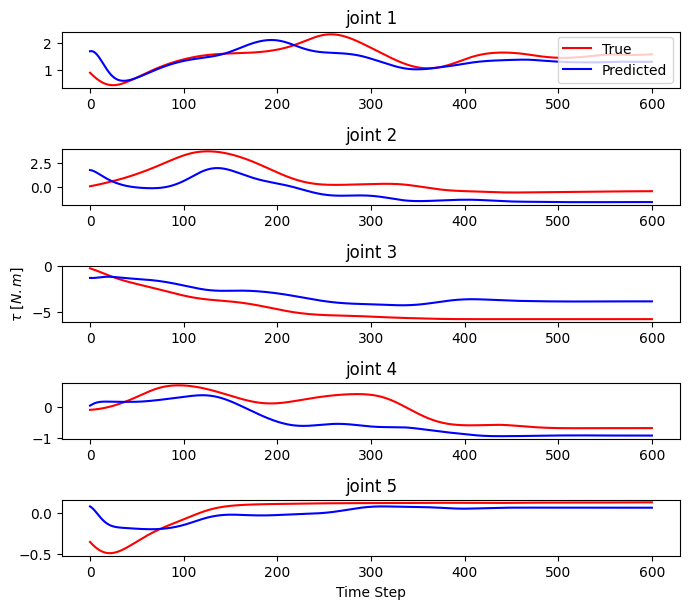

In [ ]:
# Plot the output on the first test trajectory

fig, axs = plt.subplots(5, 1, figsize=(7,6))

# Plot each output separately
for k, ax in enumerate(axs):
  ax.plot(test_output[1154:, k], label='True', color='red')
  ax.plot(test_predictions[1154:, k], label='Predicted', color='blue')
  ax.set_title(f'joint {k+1}')

axs[2].set_ylabel(r'$\tau$ [$N.m$]')
plt.tight_layout()
plt.xlabel('Time Step')
axs[0].legend(loc='right')
plt.show()

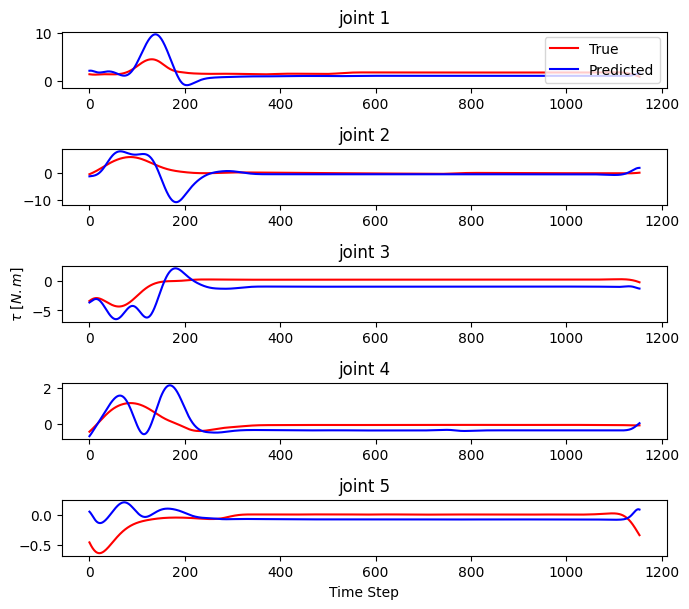

In [ ]:
# Plot the output on the second test trajectory

fig, axs = plt.subplots(5, 1, figsize=(7,6))

# Plot each output separately
for k, ax in enumerate(axs):
  ax.plot(test_output[:1154, k], label='True', color='red')
  ax.plot(test_predictions[:1154, k], label='Predicted', color='blue')
  ax.set_title(f'joint {k+1}')

axs[2].set_ylabel(r'$\tau$ [$N.m$]')
plt.tight_layout()
plt.xlabel('Time Step')
axs[0].legend(loc='right')
plt.show()